In [12]:
import gym
import numpy as np
import random
import time 
import matplotlib.pyplot as plt

import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# plotting
%matplotlib inline
import time
import pylab as pl
from IPython import display


In [13]:
env = gym.make("LunarLander-v2")
env.reset()
for _ in range(1000):
    new_observation, reward, done, info = env.step(env.action_space.sample())
    arr = env.render(mode="rgb_array")
    if done:
        break

In [14]:
print(env.action_space) #[Output: ] Discrete(2)
print(env.observation_space) # [Output: ] Box(4,)


Discrete(4)
Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)


# Exercise 1 - Replay Buffer for Experience replay

The first step of this lab is to create a Replay Buffer that will allow us to use Experience Replay and mini-batch learning.
- First, we create a class Transition using named tuple, which holds state transition in a dedicated data structure.
- Then, create a Replay Memory class that collects transition in a First In First Out fashion (fixed memory size). This Replay memory should convert the states, action, rewards into tensors.

The models presented in the Pytorch tutorial are quite generic and can be used as is.

In [15]:
from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [16]:
class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, next_state, reward):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        state_tensor = T.from_numpy(state)
        
        if next_state is None:
            state_tensor_next = None            
        else:
            state_tensor_next = T.from_numpy(next_state)
        
        action_tensor = torch.tensor([action], device=device).unsqueeze(0)

        reward = torch.tensor([reward], device=device).unsqueeze(0)/10. # reward scaling

        self.memory[self.position] = Transition(state_tensor, action_tensor, state_tensor_next, reward)  # save the transition
        self.position = (self.position + 1) % self.capacity  # loop around memory

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Exercise 2: Q-network

A Q-network is a neural network that maps states to Q-values for each actions.

Implement a first version of Q-networks.
Keep it simple (e.g. 3 hidden layers, with Relu activations).


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):

    def __init__(self, input_size, size_hidden, output_size):
        
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, size_hidden)
        #self.bn1 = nn.BatchNorm1d(size_hidden)
        
        self.fc2 = nn.Linear(size_hidden, size_hidden)   
        #self.bn2 = nn.BatchNorm1d(size_hidden)

        self.fc3 = nn.Linear(size_hidden, size_hidden)  
        #self.bn3 = nn.BatchNorm1d(size_hidden)

        self.fc4 = nn.Linear(size_hidden, output_size)
        
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x.float()))  # self.bn1()
        h2 = F.relu(self.fc2(h1))  # self.bn2()
        h3 = F.relu(self.fc3(h2))  # self.bn3()
        output = self.fc4(h3) # .view(h3.size(0), -1)
        return output
    

# Exercise 3 - Set up the Q-networks

In DQN, the weights of the target network are copied from the weights of policy network every few iterations.

We set the frequency of update using TARGET_UPDATE = 10.

Instead of RMSprop we will use SGD. 

In [18]:
OBS_SIZE = 8
HIDDEN_SIZE = 64
ACTION_SIZE = 4

Q_network = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target.load_state_dict(Q_network.state_dict())
Q_target.eval()

TARGET_UPDATE = 20

optimizer = optim.Adam(Q_network.parameters(), lr=0.001)
memory = ReplayMemory(100000)

#for p in Q_network.parameters():
#    print(p)

# Exercise 4 - Epsilon-greedy policy

You can take inspiration from pytorch tutorial and implement the select_action function.
Or, alternatively, you can implement a E-greedy policy class that will select epsilon greedy actions..


In [19]:
class E_Greedy_Policy():
    
    def __init__(self, epsilon, decay, min_epsilon):
        
        self.epsilon = epsilon
        self.epsilon_start = epsilon
        self.decay = decay
        self.epsilon_min = min_epsilon
                
    def __call__(self, state):
                
        is_greedy = random.random() > self.epsilon
        if is_greedy :
            # we select greedy action
            with torch.no_grad():
                Q_network.eval()
                index_action = Q_network(state).argmax().detach().cpu().numpy().item()
                Q_network.train()

        else:
            # we sample a random action
            index_action = env.action_space.sample() # select random action (4 possible values)
        
        return index_action
                
    def update_epsilon(self):
        
        self.epsilon = self.epsilon*self.decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min
        
    def reset(self):
        self.epsilon = self.epsilon_start
        
        
policy = E_Greedy_Policy(epsilon=0.5, decay=0.997, min_epsilon=0.001)

# Exercise 5 - Training loop

In [20]:
BATCH_SIZE = 256
GAMMA = 0.99

def optimize_model():
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    non_final_next_states = torch.reshape(non_final_next_states, (non_final_mask.sum(), -1))  # Reshape to (nr. non final, 8)

    state_batch = torch.cat(batch.state)
    state_batch = torch.reshape(state_batch, (BATCH_SIZE, -1))  # Reshape to (batch_size, 8)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q values using policy net
    Q_values = Q_network(state_batch).gather(1, action_batch)

    # Compute next Q values using Q_targets
    next_Q_values = torch.zeros( BATCH_SIZE, device=device)
    next_Q_values[non_final_mask] = Q_target(non_final_next_states).max(1)[0].detach()
    next_Q_values = next_Q_values.unsqueeze(1)
    
    # Compute targets
    target_Q_values = (next_Q_values * GAMMA) + reward_batch
    
    # Compute MSE Loss
    loss = F.mse_loss(Q_values, target_Q_values)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # Trick: gradient clipping
    for param in Q_network.parameters():
        param.grad.data.clamp_(-1, 1)
        
    optimizer.step()
    
    return loss

In [21]:
env = gym.make("LunarLander-v2")  # create environment

num_episodes = 500
policy.reset()
rewards_history = []

# Warmup phase!
memory_filled = False

while not memory_filled:
    
    state = env.reset()  # 8 states: coordinates of the lander (x,y), linear velocities (x,y), angle, angular velocity, 2 bools if each leg is touches ground.
    done = False
    total_reward = 0
    
    while not done:  # for each episode
        # Get action and act in the world
        state_tensor = T.from_numpy(state)
        action = policy(state_tensor)  # <<--- choose greedy (choose index of highest q-value predicted by network) or exploration
        next_state, reward, done, __ = env.step(action)
        total_reward += float(reward)
        
        # Observe new state
        if done:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, float(reward))
        state = next_state

    memory_filled = memory.capacity == len(memory)

print('Done with the warmup')
    
    
for i_episode in range(num_episodes):
    # New dungeon at every run
    state = env.reset()
    done = False
    total_reward = 0
    
    
    while not done:  # iterate through states
        
        # Get action and act in the world
        state_tensor = T.from_numpy(state)
        
        action = policy(state_tensor)   # choose greedy (index of q-value predictions) or exploration
        next_state, reward, done, __ = env.step(action)
        total_reward += float(reward)
        
        # Observe new state
        if done:
            next_state = None
        memory.push(state, action, next_state, float(reward))  # Store the transition in memory
        state = next_state  # Move to the next state

        # Perform one step of the optimization
        #started_training = True
        loss = optimize_model()

    policy.update_epsilon()
    rewards_history.append( float(total_reward) )

    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:

        Q_target.load_state_dict(Q_network.state_dict())
    
    # if i_episode % 10 == 0: 
    #     env.render()
    if i_episode % 10 == 0:
        print('Episode {} - reward: {:.3f}, eps: {:.3f} loss: {:.3f} avg. loss: {:.3f}'.format(
            i_episode, total_reward, policy.epsilon, loss.detach().cpu(), sum(rewards_history[-10:])/10))   

print('Complete')


Exception ignored in: <function Viewer.__del__ at 0x000001C98E4031F0>
Traceback (most recent call last):
  File "C:\Users\sdien\Anaconda3\envs\DRL\lib\site-packages\gym\envs\classic_control\rendering.py", line 185, in __del__
    self.close()
  File "C:\Users\sdien\Anaconda3\envs\DRL\lib\site-packages\gym\envs\classic_control\rendering.py", line 101, in close
    self.window.close()
  File "C:\Users\sdien\Anaconda3\envs\DRL\lib\site-packages\pyglet\window\win32\__init__.py", line 319, in close
    super(Win32Window, self).close()
  File "C:\Users\sdien\Anaconda3\envs\DRL\lib\site-packages\pyglet\window\__init__.py", line 838, in close
    app.windows.remove(self)
  File "C:\Users\sdien\Anaconda3\envs\DRL\lib\_weakrefset.py", line 114, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x000001C99D62B590; to 'Win32Window' at 0x000001C98E3F4E80>


Done with the warmup
Episode  0 :  reward : -88.23492870604538 eps:  0.4985  loss: tensor(0.1188)
Average loss: -8.823492870604538
Episode  10 :  reward : -152.88732679026947 eps:  0.48374528580903503  loss: tensor(0.7325)
Average loss: -267.51907919134624
Episode  20 :  reward : -317.9083484315502 eps:  0.4694272849397492  loss: tensor(0.2673)
Average loss: -122.26933310707413
Episode  30 :  reward : -349.48619935351746 eps:  0.4555330714538382  loss: tensor(0.1563)
Average loss: -222.47882365476607
Episode  40 :  reward : -52.870052899134436 eps:  0.4420501019978025  loss: tensor(0.0122)
Average loss: -132.0407861167999
Episode  50 :  reward : -43.07078411541557 eps:  0.4289662044791175  loss: tensor(0.0767)
Average loss: -95.11433643952732
Episode  60 :  reward : -105.01173481728462 eps:  0.41626956707756796  loss: tensor(0.1205)
Average loss: -95.33160295180252
Episode  70 :  reward : -6.636696995642566 eps:  0.40394872758182826  loss: tensor(0.1084)
Average loss: -147.171396675491

KeyboardInterrupt: 

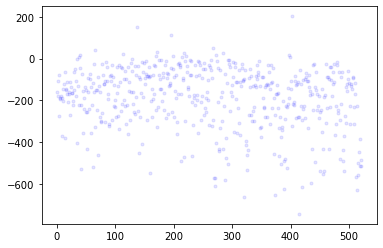

In [ ]:
plt.plot(rewards_history, 'b.', alpha=.1)